In [1]:
import numpy as np
import scipy as sp
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

from generate import Generate
from villainEM import VillainEM

# Automatically reload imports.
#%load_ext autoreload
#%autoreload 2

def multiple_runs(pics, face_size, n_init=3):
    faces = []
    bkgs = []
    lls = []
    for iter in xrange(n_init):
        detective = VillainEM(max_iter=10, h=face_size[0], w=face_size[1], random_init=True)
        detective.fit(pics)
        faces.append(detective.F)
        bkgs.append(detective.B)
        lls.append(detective.log_likelihood)
    return faces, bkgs, lls

# Testing data generation

In [2]:
pics = Generate("bayes.png", (30, 30), "face.png", (12, 10), 1000, 100)

# 1. Random initialization robustness

In [4]:
Fs, Bs, Lls = multiple_runs(pics, (12, 10))

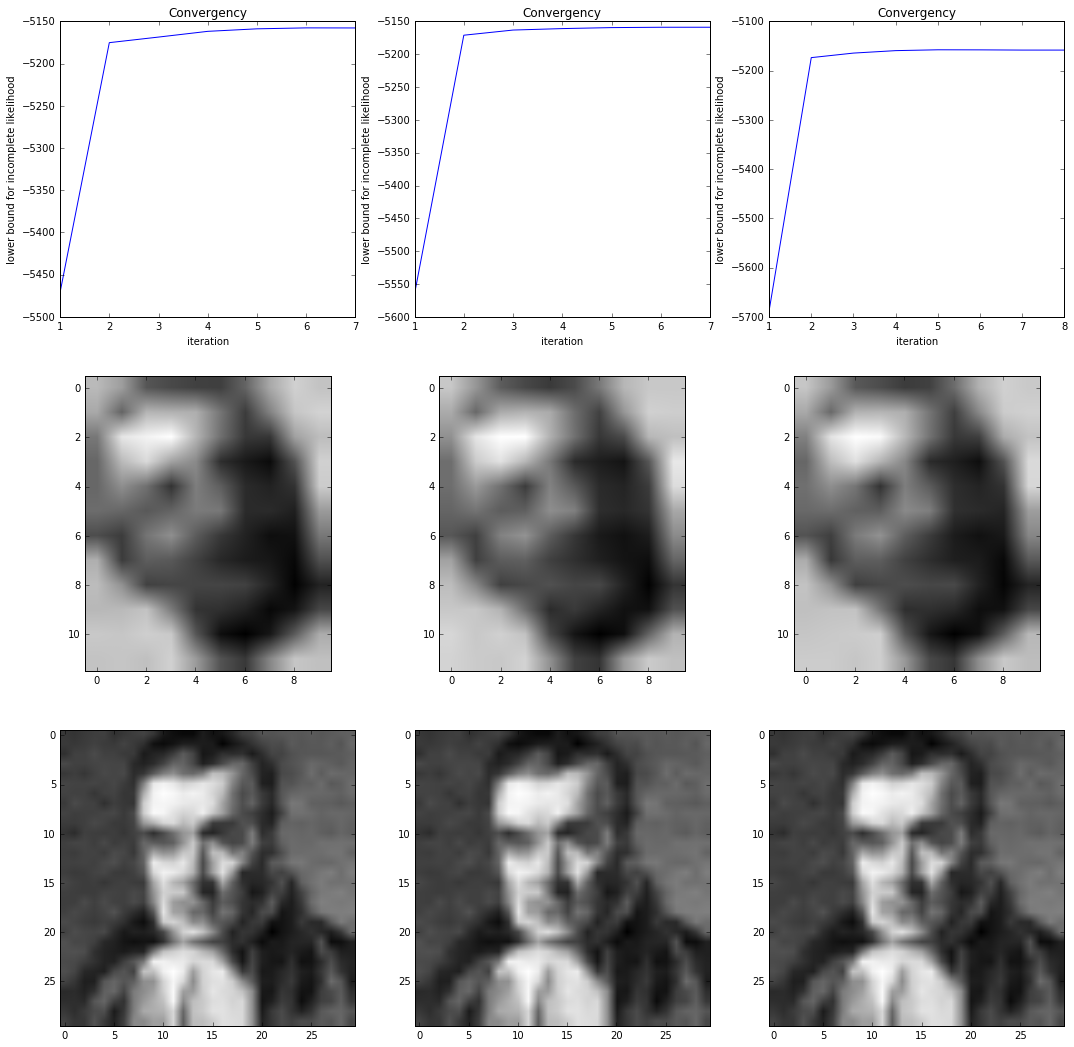

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(18,18))

for i in xrange(3):
    axes[0, i].plot(Lls[i])
    axes[0, i].set_xlabel("iteration")
    axes[0, i].set_ylabel("lower bound for incomplete likelihood")
    axes[0, i].set_title("Convergency")
    axes[1, i].imshow(Fs[i], cmap="gray")
    axes[2, i].imshow(Bs[i], cmap="gray")

With appropriate number of iterations our EM-algorithm converges to the same results regardless of random initialization. So there is no need to run it several times.<br/>Moreover there are quite elegant ways to obtain good initialization values for all variables instead of using random values (they will be discussed further).

# 2. Size and noise robustness.

In [ ]:
sigma = 0
mn = pics.mean(axis=2)
for i in xrange(pics.shape[2]):
    sigma += ((pics[:, :, i] - mn)**2).sum()
print np.sqrt(sigma/pics.shape[0]/pics.shape[1]/pics.shape[2])
plt.imshow(mn, cmap="gray")

In [ ]:
pics = np.uint8(np.load("../../../../Downloads/CameraData.npy"))

H = pics.shape[0]
W = pics.shape[1]
h = 96
w = 75
dh = H-h+1
dw = W-w+1

N = pics.shape[2]

In [ ]:
pics.shape

In [ ]:
plt.imshow(pics[:, :, 5], cmap="gray")

In [ ]:
sigma = 0
mn = pics.mean(axis=2)
for i in xrange(N):
    sigma += ((pics[:, :, i] - mn)**2).sum()
print np.sqrt(sigma/N/H/W)
plt.imshow(mn, cmap="gray")

In [ ]:
face = np.zeros((h, w))

for k in xrange(N):
    pic = pics[:, :, k] - mn
    dd = 0
    max_s = 0
    for d in xrange(dh*dw):
        pos_i = d/dw
        pos_j = d%dw
        s = np.fabs(pic[pos_i:pos_i+h, pos_j:pos_j+w].sum())
        if s > max_s:
            dd, max_s = d, s
    face += pics[dd/dw:dd/dw+h, dd%dw:dd%dw+w, k]
    
face = np.uint8(face/N)

In [ ]:
plt.imshow(face, cmap="gray")

In [ ]:
pxlhntr = villainEM(max_iter=5, hard=False)

In [ ]:
pxlhntr.fit(pics)

In [ ]:
plt.imshow(pxlhntr.B, cmap="gray")

In [ ]:
plt.imshow(pxlhntr.F, cmap="gray")

In [ ]:
pxlhntr.sigma

In [ ]:
plt.imshow(pxlhntr.weights, cmap="gray")

In [ ]:
pxlhntr.test.max(axis=(0,1))

$$p(x, \mathbf{d}|\boldsymbol{\theta}) =  p(\mathbf{d})p(x|\mathbf{d}, \boldsymbol{\theta})$$

Let's define indexes of face points as: 
$$Face(\mathbf{d}) = \{(ij): d_h \leq i < d_h + h, d_w \leq i < d_w + w\}$$.

$$p(x|\mathbf{d}, \boldsymbol{\theta}) = \prod_{(ij) \in Face(\mathbf{d})} \mathcal{N}(x_{ij}|f_{i-d_h, j-d_w}, \sigma^2) \prod_{(ij) \notin Face(\mathbf{d})} \mathcal{N}(x_{ij}|b_{ij}, \sigma^2)$$

$$p(d_h = i, d_w = j) = w_{ij}$$

Then latents variables are $\mathbf{d}$, parameters of model are $\boldsymbol{\theta} = \{\mathbf{W}, \mathbf{F}, \mathbf{B}, \sigma^2\}$.

E-step

$$p(\mathbf{D}|\mathbf{X}, \boldsymbol{\theta}) = \prod_{n=1}^N p(\mathbf{d}_n|x_n, \boldsymbol{\theta}) = \prod_{n=1}^N \frac{p(x_n, \mathbf{d}_n| \boldsymbol{\theta})}{p(x_n|\boldsymbol{\theta})} = \prod_{n=1}^N \frac{p(\mathbf{d_n})p(x_n|\mathbf{d_n}, \boldsymbol{\theta})}{\sum\limits_{\mathbf{d}}p(\mathbf{d})p(x_n|\mathbf{d}, \boldsymbol{\theta})}$$

$$\gamma^n_{ij} = p(d^n_h = i, d^n_w = j|x_n, \boldsymbol{\theta})$$

M-step

For $\mathbf{W}$:

$$\mathbb{E}[\log p(\mathbf{X}, \mathbf{D}|\boldsymbol{\theta})] = \sum_{n=1}^N \sum_{ij} \gamma^n_{ij} \log w_{ij} + \mathit{const}$$
$$\frac{\partial}{\partial w_{kl}} \Big[\sum_{n=1}^N \sum_{ij} \gamma^n_{ij} \log w_{ij} + \lambda (\sum_{ij} w_{ij} - 1) + \mathit{const}\Big] = \sum_{n=1}^N \frac{\gamma^n_{kl}}{w_{kl}} + \lambda = 0$$
$$\mathbf{W} = \frac{\sum\limits_{n=1}^N\boldsymbol{\Gamma}_n}{\sum\limits_{n=1}^N\sum\limits_{ij}\gamma^n_{ij}}$$
\noindent
For $\mathbf{F}$:

$$\mathbb{E}[\log p(\mathbf{X}, \mathbf{D}|\boldsymbol{\theta})] = - \sum_{ij} \sum_{n=1}^N \gamma^n_{ij} \sum_{(kl) \in Face(ij)} \frac{(x^n_{kl} - f_{k - i, l - j})^2}{2\sigma^2} + \mathit{const}$$
$$f_{ij} = \frac{\sum\limits_{kl} \sum\limits_{n=1}^N \gamma^n_{kl} x^n_{k+i,l+j}}{\sum\limits_{kl} \sum\limits_{n=1}^N \gamma^n_{kl}}$$
\noindent
For $\mathbf{B}$:

$$\mathbb{E}[\log p(\mathbf{X}, \mathbf{D}|\boldsymbol{\theta})] = - \sum_{ij} \sum_{n=1}^N \gamma^n_{ij} \sum_{(kl) \notin Face(ij)} \frac{(x^n_{kl} - b_{kl})^2}{2\sigma^2} + \mathit{const}$$
$$b_{ij} = \frac{\sum\limits_{(ij) \notin Face(kl)} \sum\limits_{n=1}^N \gamma^n_{kl} x^n_{ij}}{\sum\limits_{(ij) \notin Face(kl)} \sum\limits_{n=1}^N \gamma^n_{kl}}$$

\noindent
For $\sigma^2$:
$$\mathbb{E}[\log p(\mathbf{X}, \mathbf{D}|\boldsymbol{\theta})] = - \frac{N}{2}\log \sigma^2 -$$ $$ - \frac{1}{2\sigma^2} \sum_{ij} \sum_{n=1}^N \gamma^n_{ij} \Big[ \sum_{(kl) \in Face(ij)} (x^n_{kl} - f_{k - i, l - j})^2 + \sum_{(kl) \notin Face(ij)} (x^n_{kl} - b_{kl})^2 \Big] + \mathit{const}$$

$$\sigma^2 = \frac{1}{N}\sum_{ij} \sum_{n=1}^N \gamma^n_{ij} \Big[ \sum_{(kl) \in Face(ij)} (x^n_{kl} - f_{k - i, l - j})^2 + \sum_{(kl) \notin Face(ij)} (x^n_{kl} - b_{kl})^2 \Big]$$

In [ ]:
from scipy.stats import norm
from scipy.misc import logsumexp

In [ ]:
H = pics.shape[0]
W = pics.shape[1]
h = 96
w = 75
dh = H-h+1
dw = W-w+1

N = pics.shape[2]

weights = np.ones((dh, dw), dtype=np.float32)
weights /= weights.sum()
F = 127*np.ones((h,w), dtype=np.uint8)
B = np.uint8(pics.mean(axis=2))
sigma = 0.0
for i in xrange(pics.shape[2]):
    sigma += ((pics[:, :, i] - B)**2).sum()
sigma = np.sqrt(sigma/H/W/N)

In [ ]:
log_bkg_probs = norm.logpdf(np.kron(np.ones((H, W, 1), dtype=np.uint8), np.arange(256).reshape((1, 1, 256))),
                            np.kron(B.reshape(H, W, 1), np.ones((1, 1, 256), dtype=np.uint8)), sigma)
pixW, pixH = np.meshgrid(np.arange(W), np.arange(H))
pixH = np.kron(pixH.reshape(H, W, 1), np.ones(N, dtype=np.int))
pixW = np.kron(pixW.reshape(H, W, 1), np.ones(N, dtype=np.int))
log_bkg = log_bkg_probs[pixH, pixW, pics]

In [ ]:
log_face_probs = norm.logpdf(np.kron(np.ones((h, w, 1), dtype=np.uint8), np.arange(256).reshape((1, 1, 256))),
                             np.kron(F.reshape(h, w, 1), np.ones((1, 1, 256), dtype=np.uint8)), sigma)
pixw, pixh = np.meshgrid(np.arange(w), np.arange(h))
pixh = np.kron(pixh.reshape(h, w, 1), np.ones(N, dtype=np.int))
pixw = np.kron(pixw.reshape(h, w, 1), np.ones(N, dtype=np.int))

In [ ]:
log_gamma = np.zeros((dh, dw, N), dtype=np.float64)
for d in xrange(dh*dw):
    pos_i = d/dw
    pos_j = d%dw
    log_face = log_face_probs[pixh, pixw, pics[pos_i:pos_i+h, pos_j:pos_j+w]]
    log_pics = log_bkg.copy()
    log_pics[pos_i:pos_i+h, pos_j:pos_j+w] = log_face
    log_gamma[pos_i, pos_j] = np.log(weights[pos_i, pos_j]) + log_pics.sum(axis=(0,1))

In [ ]:
log_likelihood = logsumexp(log_gamma)
gamma = np.exp(log_gamma - logsumexp(log_gamma, axis=(0,1)).reshape((1,1,N)))

In [ ]:
positions = log_gamma.reshape((dh*dw, N)).argmax(axis=0)
pos_i = positions/dw
pos_j = positions%dw

In [ ]:
weights *= 0.0
pos, n = np.unique(positions, return_counts=True)
weights[pos/dw, pos%dw] += np.float32(n)/N

In [ ]:
pos.shape

In [ ]:
plt.imshow(weights, cmap="gray")

In [ ]:
nbkg = np.zeros((H, W), dtype=np.float32)
bkgnorm = N*np.ones((H, W), dtype=np.int32)
nface = np.zeros((h, w), dtype=np.float32)
for n in xrange(N):
    picbuf = pics[:, :, n].copy()
    picbuf[pos_i[n]:pos_i[n]+h, pos_j[n]:pos_j[n]+w] = 0
    nbkg += picbuf
    bkgnorm[pos_i[n]:pos_i[n]+h, pos_j[n]:pos_j[n]+w] -= 1
    nface += pics[pos_i[n]:pos_i[n]+h, pos_j[n]:pos_j[n]+w, n]
nface /= N
nbkg /= bkgnorm

sgm = np.zeros(1, dtype=np.float64)
for n in xrange(N):
    picbuf = nbkg.copy()
    picbuf[pos_i[n]:pos_i[n]+h, pos_j[n]:pos_j[n]+w] = nface.copy()
    sgm += ((pics[:, :, n]-picbuf)**2).sum()/H/W
sgm = np.sqrt(sgm/N)

In [ ]:
plt.imshow(nface, cmap="gray")

In [ ]:
plt.imshow(nbkg, cmap="gray")

In [ ]:
print sgm

In [ ]:
wnew = gamma.sum(axis=2)/gamma.sum()

In [ ]:
Fnew = np.zeros(F.shape, dtype=np.float64)
for d in xrange(dh*dw):
    pos_i = d/dw
    pos_j = d%dw
    Fnew += (gamma[pos_i, pos_j].reshape((1, 1, N))*pics[pos_i:pos_i+h, pos_j:pos_j+w]).sum(axis=2)
F = np.uint8(Fnew/N)

In [ ]:
plt.imshow(F, cmap="gray")

In [ ]:
Bnew = np.zeros(B.shape, dtype=np.float64)
for d in xrange(dh*dw):
    pos_i = d/dw
    pos_j = d%dw
    Bnew += (gamma[pos_i, pos_j].reshape((1, 1, N))*pics).sum(axis=2)
B = np.uint8(Bnew/N)

In [ ]:
plt.imshow(B, cmap="gray")

In [ ]:
plt.imshow(pics.mean(axis=2), cmap="gray")

In [ ]:
((B == np.uint8(pics.mean(axis=2))) == False).sum()

In [ ]:
print H
print W
print h
print w
print H-h+1
print W-w+1

In [ ]:
A = np.zeros((3, 3, 5))

In [ ]:
AA = np.arange(9).reshape((3, 3, 1))

In [ ]:
AAA = A + AA

In [ ]:
AAA.reshape((9, 5)).argmax(axis=0)

In [ ]:
AAA.argmax(axis=1)

In [ ]:
A = np.arange(10)
print A.std()
A[A > 5] = 5
print A.std()